In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import string, re
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import WordNetLemmatizer 
from nltk.probability import FreqDist

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_json('news.json',lines=True)

In [3]:
df.head(1)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26


In [4]:
# list of all categories that the articles are categorized by
categories = list(df.category.unique())

In [5]:
categories

['CRIME',
 'ENTERTAINMENT',
 'WORLD NEWS',
 'IMPACT',
 'POLITICS',
 'WEIRD NEWS',
 'BLACK VOICES',
 'WOMEN',
 'COMEDY',
 'QUEER VOICES',
 'SPORTS',
 'BUSINESS',
 'TRAVEL',
 'MEDIA',
 'TECH',
 'RELIGION',
 'SCIENCE',
 'LATINO VOICES',
 'EDUCATION',
 'COLLEGE',
 'PARENTS',
 'ARTS & CULTURE',
 'STYLE',
 'GREEN',
 'TASTE',
 'HEALTHY LIVING',
 'THE WORLDPOST',
 'GOOD NEWS',
 'WORLDPOST',
 'FIFTY',
 'ARTS',
 'WELLNESS',
 'PARENTING',
 'HOME & LIVING',
 'STYLE & BEAUTY',
 'DIVORCE',
 'WEDDINGS',
 'FOOD & DRINK',
 'MONEY',
 'ENVIRONMENT',
 'CULTURE & ARTS']

### Text Classfication
Going to use the headline and the short description to try and predict the category.

In [6]:
df.headline[0]

'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV'

In [7]:
df.short_description[0]

'She left her husband. He killed their children. Just another day in America.'

Going to use the headline and the short description as the same importance. Combining the two will then be used to try and predict the category that it belongs to based on the words used.

In [8]:
# adding a period at the end of the headline to be combined
#   with the short description
df.headline = df.headline+'. '
# combining the two together
df['text'] = df.headline + df.short_description

In [9]:
print(df.text[0])

There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV. She left her husband. He killed their children. Just another day in America.


In [10]:
data = df.text
target = df.category

Now to get the more important words in the descriptions I am going to remove the stop words. Stop words are words like and, or, the, and many more that do not give any 'information' on what that article title/short description is describing.

If the word 'gun' appears in an article title then the article is most likely about crime and not entertainment. If the word 'baseball' appears in an article then it is most likely about sports. There are interesting words like 'court' where it could be referring to a basketball court or a court where trails in criminal and civil cases are conducted.

In [69]:
# going to filter out stopwords and punctions to get root words
stop_words = stopwords.words('english')
stop_words += list(string.punctuation)
stop_words += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
            'said', 'one', 'com', '-', '–', '—',"'","'s","n't"]
stop_words = set(stop_words)

In [70]:
# going to remove the stopwords from the data
# splitting data into tokens meaning a list of individual words
def remove_stopwords(article_text):
    '''
    INPUT: Text of any kind
    OUTPUT: Text with all stop words removed
    '''
    tokens = nltk.word_tokenize(article_text)
    article_without_stopwords = [token.lower() for token in tokens if token.lower() not in stop_words]
    return article_without_stopwords
    
data_wo_stopwords = list(map(remove_stopwords,data))

In [71]:
print('Normal:')
print(data[0]+'\n')
print('Tokenized + Removed Stop Words:')
print(data_wo_stopwords[0])

Normal:
There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV. She left her husband. He killed their children. Just another day in America.

Tokenized + Removed Stop Words:
['2', 'mass', 'shootings', 'texas', 'last', 'week', '1', 'tv', 'left', 'husband', 'killed', 'children', 'another', 'day', 'america']


In [72]:
# the total vocab is a list of all words used in every article
total_vocab = set()
for word in data_wo_stopwords:
    total_vocab.update(word)
len(total_vocab)

118694

Going to lemmatize the text data in order to reduce the total vocab. Lemmatization is the process of removing different conguations of the same word. Organize, organizes, and organizing are all the same word but with different endings to describe if it is happening and when it is happening. The process of lemmatization will remove these so that all 3 words will transform just into organize and will be treated the same.

In [73]:
lemmatized_data = []

lemmatizer = WordNetLemmatizer()

for article in data_wo_stopwords:
    lemmatized_article = ' '.join([lemmatizer.lemmatize(word) for word in article])
    lemmatized_data.append(lemmatized_article)

In [74]:
print('Normal:')
print(data[0],'\n')
print('Tokenized + Removed Stop Words:')
print(data_wo_stopwords[0],'\n')
print('Lemmatized:')
print(lemmatized_data[0])

Normal:
There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV. She left her husband. He killed their children. Just another day in America. 

Tokenized + Removed Stop Words:
['2', 'mass', 'shootings', 'texas', 'last', 'week', '1', 'tv', 'left', 'husband', 'killed', 'children', 'another', 'day', 'america'] 

Lemmatized:
2 mass shooting texas last week 1 tv left husband killed child another day america


In [75]:
X = lemmatized_data
y = target

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=99)

In [77]:
tfidf = TfidfVectorizer()
# creating the tfidf which will train off the documents bsased on 'important' words
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

In [78]:
tfidf_train

<160682x71956 sparse matrix of type '<class 'numpy.float64'>'
	with 2574597 stored elements in Compressed Sparse Row format>

From this we can see that this is an extremely sparse matrix meaning there are many 0 values meaning that words are only in a few amount of documents.

In [79]:
non_zero_cols = tfidf_train.nnz / float(tfidf_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_train.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 16.02293349597341
Percentage of columns containing ZERO: 0.9997773231767195


Going to look at what words are associated with each category. These are the words that are most frequent within the documents of each category. Just for example going to do 5.

In [80]:
# isolating categories
df_crime = df[df.category == 'CRIME']
df_entertainment = df[df.category == 'ENTERTAINMENT']
df_sports = df[df.category == 'SPORTS']
df_tech = df[df.category == 'TECH']
df_politics = df[df.category == 'POLITICS']

In [81]:
# isolating text from the articles
crime_data = df_crime.text
entertainment_data = df_entertainment.text
sports_data = df_sports.text
tech_data = df_tech.text
politics_data = df_politics.text

In [82]:
# this is the the same removing of stop words that we did before
crime_clean = list(map(remove_stopwords,crime_data))
entertainment_clean = list(map(remove_stopwords,entertainment_data))
sports_clean = list(map(remove_stopwords,sports_data))
tech_clean = list(map(remove_stopwords,tech_data))
politics_clean = list(map(remove_stopwords,politics_data))

In [83]:
# data is now in a list of lists and to look at words 
#. frequency we need a flat list of n x 1
crime_flat = [item for sublist in crime_clean for item in sublist]
entertainment_flat = [item for sublist in entertainment_clean for item in sublist]
sports_flat = [item for sublist in sports_clean for item in sublist]
tech_flat = [item for sublist in tech_clean for item in sublist]
politics_flat = [item for sublist in politics_clean for item in sublist]

In [84]:
# now we will use frequency distribution to identify the words most common in those articles
crime_fdist = FreqDist(crime_flat)
entertainment_fdist = FreqDist(entertainment_flat)
sports_fdist = FreqDist(sports_flat)
tech_fdist = FreqDist(tech_flat)
politics_fdist = FreqDist(politics_flat)

In [85]:
crime_fdist.most_common(10)

[('police', 817),
 ('man', 562),
 ('shooting', 357),
 ('suspect', 278),
 ('allegedly', 265),
 ('killed', 256),
 ('found', 249),
 ('say', 242),
 ('woman', 242),
 ('shot', 231)]

In [86]:
entertainment_fdist.most_common(10)

[('new', 1867),
 ('trump', 880),
 ('film', 868),
 ('show', 856),
 ('first', 817),
 ('like', 811),
 ('movie', 804),
 ('says', 736),
 ('star', 706),
 ("'the", 672)]

In [87]:
sports_fdist.most_common(10)

[('nfl', 483),
 ('game', 436),
 ('team', 368),
 ('football', 348),
 ('world', 325),
 ('first', 315),
 ('new', 285),
 ('video', 274),
 ('sports', 266),
 ('player', 264)]

In [88]:
tech_fdist.most_common(10)

[('apple', 408),
 ('new', 337),
 ('facebook', 311),
 ('google', 262),
 ('week', 247),
 ("'re", 180),
 ('iphone', 176),
 ('twitter', 154),
 ('tech', 140),
 ('--', 132)]

In [89]:
politics_fdist.most_common(10)

[('trump', 12716),
 ('donald', 4371),
 ('president', 3088),
 ('clinton', 2609),
 ('new', 2507),
 ('gop', 2470),
 ('obama', 2341),
 ('says', 2118),
 ('house', 2083),
 ('hillary', 1856)]

From this we can see that the most common words do have a good indication of what category they belong to. I would say that these make a lot of sense and would have a lot of power when categorizing articles.

### Visualization

In [133]:
crime_word_counts = [x[1] for x in crime_fdist.most_common(20)]
crime_words = [x[0] for x in crime_fdist.most_common(20)]

entertainment_word_counts = [x[1] for x in entertainment_fdist.most_common(20)]
entertainment_words = [x[0] for x in entertainment_fdist.most_common(20)]

sports_word_counts = [x[1] for x in sports_fdist.most_common(20)]
sports_words = [x[0] for x in sports_fdist.most_common(20)]

tech_word_counts = [x[1] for x in tech_fdist.most_common(20)]
tech_words = [x[0] for x in tech_fdist.most_common(20)]

politics_word_counts = [x[1] for x in politics_fdist.most_common(20)]
politics_words = [x[0] for x in politics_fdist.most_common(20)]

In [142]:
# set the color of our bar graphs
color = cm.hot(np.linspace(.4,.8, 30))

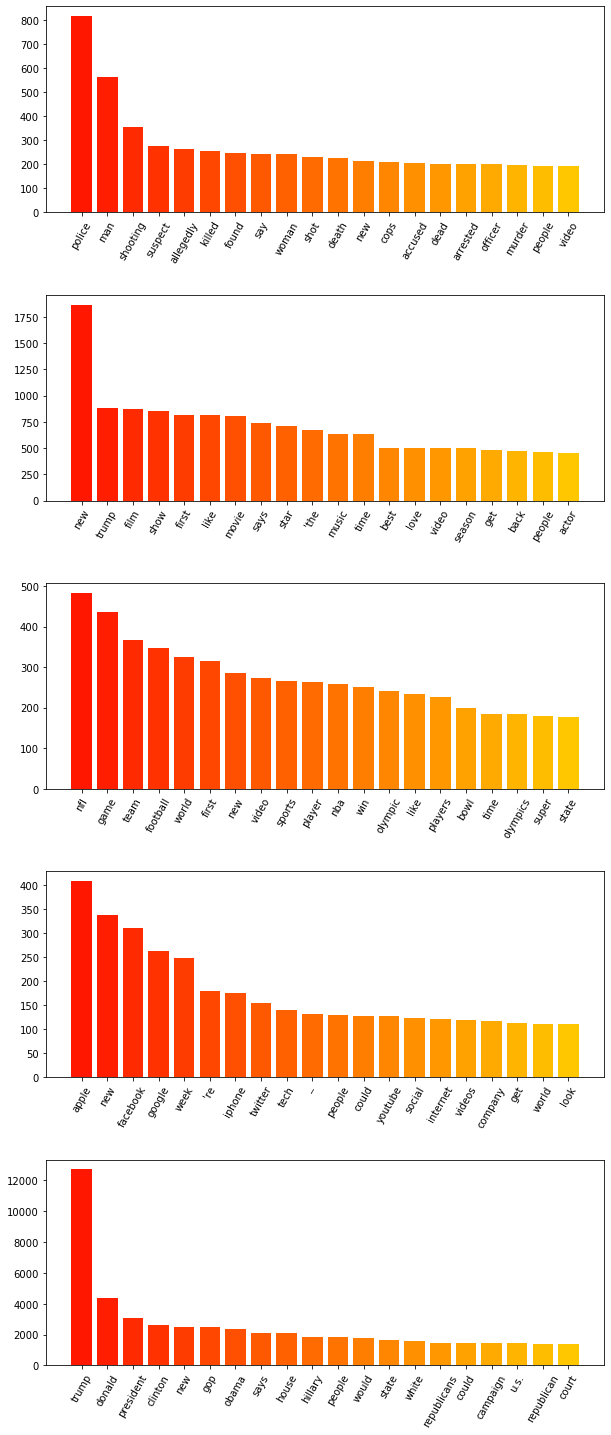

In [143]:
fig,ax = plt.subplots(nrows = 5,ncols=1,figsize=(10,25))
fig = plt.subplots_adjust(hspace=0.4)
#fig.tight_layout()
ax[0].bar(crime_words,crime_word_counts,color=color)
ax[0].set_xticklabels(crime_words, fontdict=None, minor=False, rotation=60);

ax[1].bar(entertainment_words,entertainment_word_counts,color=color)
ax[1].set_xticklabels(entertainment_words, fontdict=None, minor=False, rotation=60);

ax[2].bar(sports_words,sports_word_counts,color=color)
ax[2].set_xticklabels(sports_words, fontdict=None, minor=False, rotation=60);

ax[3].bar(tech_words,tech_word_counts,color=color)
ax[3].set_xticklabels(tech_words, fontdict=None, minor=False, rotation=60);

ax[4].bar(politics_words,politics_word_counts,color=color)
ax[4].set_xticklabels(politics_words, fontdict=None, minor=False, rotation=60);

### Classification

In [146]:
rand_forest_classifier = RandomForestClassifier(n_estimators=100,random_state=99)

rand_forest_classifier.fit(tfidf_train,y_train)

rand_forest_preds = rand_forest_classifier.predict(tfidf_test)

In [148]:
accuracy = accuracy_score(y_test,rand_forest_preds)
f1 = f1_score(y_test,rand_forest_preds,average='micro')

In [149]:
print('Accuracy = {}'.format(accuracy))
print('F1 = {}'.format(f1))

Accuracy = 0.5570436384456449
F1 = 0.5570436384456449
